In [ ]:
import cv2
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import Sequence

# 하이퍼 파라미터 설정

쥬피터 노트북 특성 상 하이퍼파라미터가 산재되어있을 수 있다. 따라서 다음과 같은 Dictionary형태로 저장해두는것도 하나의 방법이다.

In [ ]:
CONFIG = {
    "img_size" : 256,
    "learning_rate" : 3e5,
    "batch_size" : 64,
}

# 데이터 불러오기

Rood_dir : 데이터 폴더들이 있는 위치

train_root : Root_dir에 있는 train폴더의 위치

train_label_root : train_root안에 있는 _classes.csv의 위치

...

In [ ]:
Root_dir = "/content/drive/MyDrive/학교/TNT/Thermal Dogs and People.v1-resize-416x416.multiclass"

In [ ]:
train_root = Root_dir + "/train"
train_label_root = train_root + "/_classes.csv"
valid_root = Root_dir + "/valid"
valid_label_root = valid_root + "/_classes.csv"
test_root = Root_dir + "/test"
test_label_root = test_root + "/_classes.csv"

# 라벨 파일 불러오기

라벨 파일을 pandas로 불러옵니다.

이후에 라벨 파일의 column명이 공백을 포함 하고 있어 .columns를 통해 재정의 해줍니다.

In [ ]:
train_label = pd.read_csv(train_label_root)
train_label.columns = ['filename', 'dog', 'person']
valid_label = pd.read_csv(valid_label_root)
valid_label.columns = ['filename', 'dog', 'person']
test_label = pd.read_csv(test_label_root)
test_label.columns = ['filename', 'dog', 'person']

# 이미지 시각화 해보기

우리가 준비한 변수들로 데이터를 시각화 해보는 단계입니다.

여기서 사용한 라이브러리는 총 2가지인데 그 중 첫번째는 opencv라는 라이브러리 입니다. 이는 이미지 관련 처리를 할 때 가장 많이 쓰이는 라이브러리 이기 때문에 친숙해 지시면 좋습니다.

## 1. cv2.imread
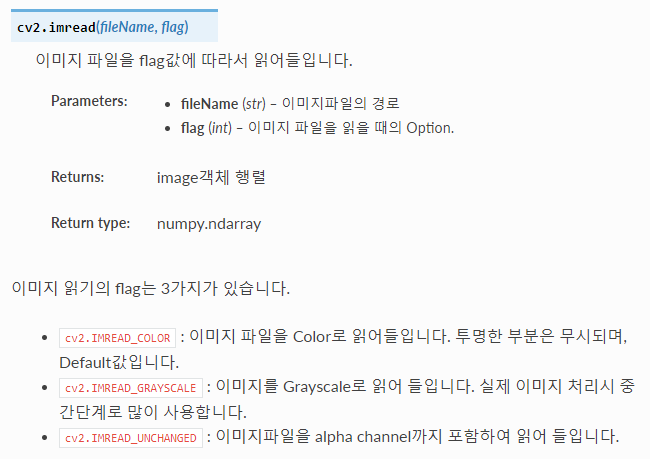

즉, 이미지를 우리가 준 flag(option)에 따라 읽고 이를 numpy형태로 반환해주는 함수 입니다.

## 2. os.listdir

두번째로는 os모듈를 사용하였습니다. os라이브러리 운영체제에서 제공하는 여러 기능을 파이썬에서 수행할 수 있게 해주는 라이브러리입니다. 즉, 파이썬을 이용해 파일을 복사하거나 디렉터리를 생성하고 특정 디렉터리 내의 파일 목록을 구하고자 할 때 os 모듈을 사용하면 됩니다.

우리는 해당 모듈에서 listdir이라는 함수를 사용하였습니다.

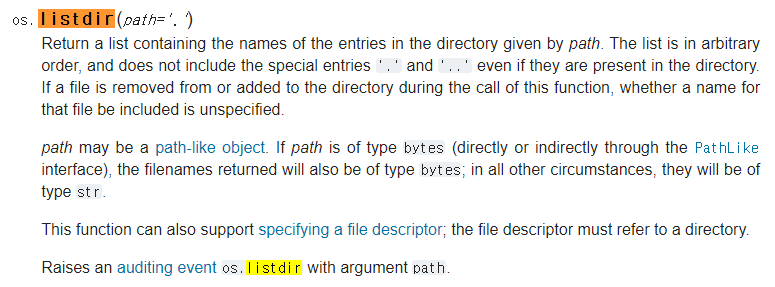

이는 경로 안에 있는 파일 들을 리스트 형태로 반환해주는 함수입니다.

우리가 다룰 이미지라는 데이터는 특정 경로안에 모아져있습니다. 따라서 이들의 파일 명을 리스트 형태로 관리해주기 위해 해당 함수를 사용했습니다.

In [ ]:
def image_show(root,label,index):
    image = cv2.imread(root + "/" + os.listdir(root)[index])
    if label[label['filename'] == os.listdir(train_root)[index]]['dog'].iloc[0] == 1 :
        target_label = 'dog'
    else :
        target_label = 'person'      
    print(target_label)
    cv2_imshow(image)
    return

# Quiz 1

image_show 함수에서

```
if label[label['filename'] == os.listdir(train_root)[index]]['dog'].iloc[0] == 1 :
```

이 부분이 왜 이렇게 만들어졌는지 설명하세요.

person


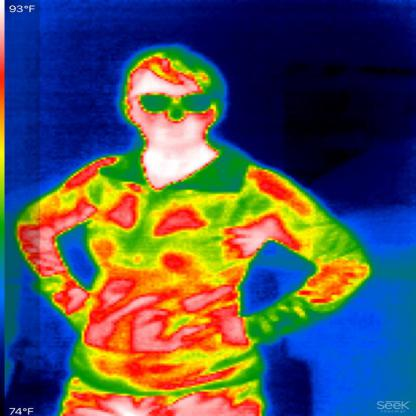

In [ ]:
image_show(train_root, train_label, 2)

# 라벨 정리하기와 손실 함수

## -> 일반적인 분류 방법

우리가 보통 분류문제를 해결하려고 할 때는 다음과 같이 모델을 설계할 것이다.
```
y = [0, 0, 1]
prediction = [0.2, 0.3, 0.5]
loss = cross_entropy(y, prediction)
```
이걸 tensorflow에서 구현하고자 하면
```
>>> y_true = [[0, 1, 0], [0, 0, 1]]
>>> y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]

>>> cce = tf.keras.losses.CategoricalCrossentropy()

>>> cce(y_true, y_pred).numpy()
1.117

```

하지만 위의 방법의 단점은 우리가 0, 1, 2로 되어 있는 라벨을 One hot encoding을 해줘야하는 것이다. 이 부분이 사실 별거 아닌것 처럼 보이지만 상당히 귀찮고 라벨이 많아 지면 메모리도 많이 차지하게 된다. 이럴 때 사용하는 loss 함수가 아래의 손실함수 이다.

## -> SparseCategoricalCrossentropy()

```
>>> y_true = [1, 2]
>>> y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]

>>> scce = tf.keras.losses.SparseCategoricalCrossentropy()
>>> scce(y_true, y_pred).numpy()

```
위와의 차이에서 볼 수 있듯이 SparseCategoricalCrossentropy를 사용하면 label을 onehot encoding을 안 해도 학습이 진행된다. 따라서 이번 실습에서는 해당 손실함수를 사용해서 진행 할 것 이다.

In [ ]:
class_label = {
    0 : "dog",
    1 : "person"
}
num_classes = 2

# Quiz 2

다음 Dataloader의 빈칸을 맞춰보세요

In [ ]:
class Dataloader(Sequence):
    def __init__(self, data_root, label_csv, batch_size, img_size,shuffle=False):
        self.label = label_csv
        self.x, self.y = self.prepare_data(data_root, label_csv)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return # code 작성하세요

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x = []
        batch_y = []        
        for i in indices:
            # 들어오는 이미지는 크기가 다를 수 있기 때문에 이를 조정해줘야합니다. tf.image.resize를 통해 이미지를 재조정 후 batch_x에 넣어보세요.
            batch_x.append('code를 작성하세요' )
            batch_y.append(self.y[i])
        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)
    
    def prepare_data(self, data_root, label_csv):
        x = []
        y = []
        for data in os.listdir(data_root):
            if data == "_classes.csv":
                pass
            else :
                # cv2.imread를 이용해서 image를 넘파이 형태로 불러와보세요
                img = 'code를 작성하세요'
                x.append(img)
                if self.label[self.label['filename'] == data]['dog'].iloc[0] == 1 :
                    target_label = 0
                else :
                    target_label = 1
                y.append(target_label)
        return x, y

In [ ]:
train_loader = Dataloader(train_root, train_label, batch_size = CONFIG['batch_size'], img_size = CONFIG["img_size"], shuffle= True)
valid_loader = Dataloader(valid_root, valid_label, batch_size = CONFIG['batch_size'], img_size = CONFIG["img_size"], shuffle= True)
test_loader = Dataloader(test_root, test_label, batch_size = 1, img_size = CONFIG["img_size"])

# 모델 만들기

이번에는 Model을 Sequential을 사용해서 만드는 것을 보여 드릴 겁니다.

## 1. 정규화 층

저번과제에서는 Dataloader에서 정규화를 추가하는 것을 실습해보았습니다. 이번에는 모델 측면에서 정규화를 해주는 layer를 배워보겠습니다.
```
layers.experimental.preprocessing.Rescailing(1./255)
```

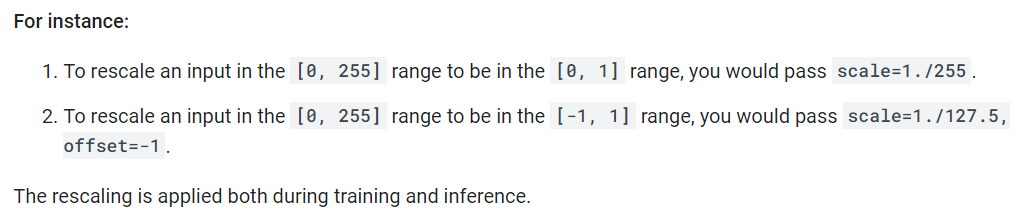

#2.Convolution layer

이번에는 Convolution layer에 대해 배워볼 것입니다. 2D라는 것은 사용하는 convolution filter가 2차원 텐서라는 것입니다. 다음 레이어의 channel수가 될 filter의 갯수와 stride를 지정해줍니다. padding의 방식은 default로 valid로 되어있습니다.
```
layers.Conv2D(filters = 32, stride = 3, activation = 'relu')
```

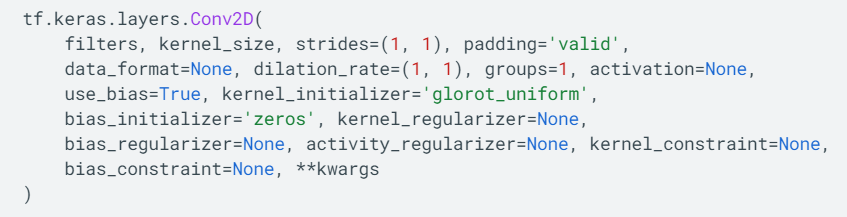

# 3. Pooling layer

이번에 우리가 사용할 Maxpooling 레이어 입니다.
이번에 사용할 MaxPooling2D는 Pooling에 지정할 영역이 2차원 텐서입니다.
```
layers.MaxPooling2D()
```

```
tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), strides=None, padding='valid', data_format=None,
    **kwargs
)
```

In [ ]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

# Quiz 3

방금 위에서 구현한 모델을 함수형 API로 만들어볼 겁니다. 다음 빈칸을 채워보세요.

In [ ]:
def layer_block(input):
    '''
    code
    '''
    return x
    
def make_model():
    inputs = tf.keras.layers.Input(shape = (CONFIG['img_size'], CONFIG['img_size'], 3))
    # Rescailing layer
    for i in range(3):
        x = layer_block(x)
    #code 

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# 모델 Compile하기

아까에서도 말했다 싶이 loss는 sparse categorical crossentropy를 사용 할 겁니다.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = CONFIG['learning_rate']),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 학습

In [ ]:
history = model.fit(train_loader, validation_data = valid_loader, epochs = 10)

Epoch 1/10
3/3 [==============================] - 1s 373ms/step - loss: 1.6422 - accuracy: 0.5634 - val_loss: 0.9340 - val_accuracy: 0.4634
Epoch 2/10
3/3 [==============================] - 1s 234ms/step - loss: 0.8745 - accuracy: 0.4085 - val_loss: 0.6601 - val_accuracy: 0.5122
Epoch 3/10
3/3 [==============================] - 1s 321ms/step - loss: 0.6500 - accuracy: 0.6761 - val_loss: 0.6191 - val_accuracy: 0.6341
Epoch 4/10
3/3 [==============================] - 1s 321ms/step - loss: 0.5743 - accuracy: 0.7183 - val_loss: 0.4636 - val_accuracy: 0.8780
Epoch 5/10
3/3 [==============================] - 1s 329ms/step - loss: 0.4519 - accuracy: 0.8380 - val_loss: 0.3266 - val_accuracy: 0.8537
Epoch 6/10
3/3 [==============================] - 1s 243ms/step - loss: 0.3608 - accuracy: 0.8592 - val_loss: 0.2899 - val_accuracy: 0.8780
Epoch 7/10
3/3 [==============================] - 1s 240ms/step - loss: 0.3171 - accuracy: 0.8873 - val_loss: 0.3557 - val_accuracy: 0.8537
Epoch 8/10
3/3 [====

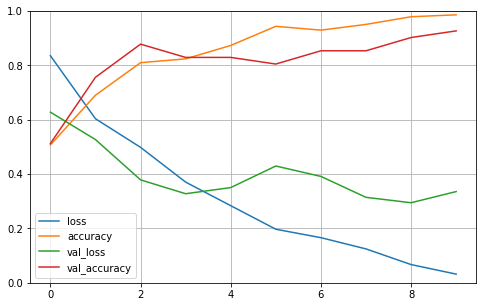

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# 테스트 결과

In [ ]:
for x, y in test_loader:
    print("="* 100)
    prediction = model(x).numpy().argmax()
    print("Prediction :", class_label[prediction], " |||   Label :", class_label[y[0]])
    cv2_imshow(x.squeeze())
    print("="* 100)